In [ ]:
#clone everything and install requirements
!git clone https://github.com/eiky0u/AVSS-Project/
%cd AVSS-Project
!git clone https://huggingface.co/eikyou/TDFNet
!git clone https://huggingface.co/Dodenus/RTFSNet
!pip install -r requirements.txt

Cloning into 'AVSS-Project'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 566 (delta 19), reused 20 (delta 12), pack-reused 516 (from 1)
Receiving objects: 100% (566/566), 752.48 KiB | 14.75 MiB/s, done.
Resolving deltas: 100% (302/302), done.
/content/AVSS-Project/AVSS-Project
Cloning into 'TDFNet'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 3), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (18/18), 6.83 KiB | 2.28 MiB/s, done.
Cloning into 'RTFSNet'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Unpacking objects: 100% (14/14), 5.66 KiB | 1.89 MiB/s, done.
Looking in indexes: https://downl

In [ ]:
import requests
from tqdm import tqdm
import zipfile
from pathlib import Path
from google.colab import userdata

def download_and_extract_yadisk(
    public_url: str,
    zip_path: str = "dataset.zip",
    extract_root: str | Path = ".",
) -> Path:
    """
    Download a public Yandex.Disk archive and extract it.

    Args:
        public_url: Public URL of the Yandex.Disk resource.
        zip_path:  Local path to save the downloaded .zip file.
        extract_root: Directory where the archive will be extracted.

    Returns:
        Path to the top-level directory inside the extracted archive.
    """
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"

    # 1. Get temporary download URL by public link
    resp = requests.get(api_url, params={"public_key": public_url})
    resp.raise_for_status()
    download_url = resp.json()["href"]

    zip_path = Path(zip_path)
    extract_root = Path(extract_root)

    # 2. Download
    with requests.get(download_url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))  # can be 0
        chunk_size = 1024 * 1024  # 1 MB

        with zip_path.open("wb") as f, tqdm(
            total=total,
            unit="B",
            unit_scale=True,
            unit_divisor=1024,
            desc="Downloading",
        ) as bar:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue
                size = f.write(chunk)
                bar.update(size)

    print(f"Download finished, saved to: {zip_path}")

    # 3. Extract
    with zipfile.ZipFile(zip_path, "r") as zf:
        members = zf.infolist()

        root_dirs = {
            m.filename.split("/")[0]
            for m in members
            if "/" in m.filename
        }

        # assuming there is a single root directory in the archive
        root_name = next(iter(root_dirs))
        base_extract_dir = extract_root

        for member in tqdm(members, desc="Extracting"):
            zf.extract(member, base_extract_dir)

    extract_dir = base_extract_dir / root_name
    print(f"\nExtraction finished, extracted to: {extract_dir}")

    return extract_dir


public_url = userdata.get('data') # INSERT YOUR PUBLIC URL HERE!!!
root_dir = download_and_extract_yadisk(public_url)

Downloading: 100%|██████████| 968M/968M [01:11<00:00, 14.2MB/s]


Download finished, saved to: dataset.zip


Extracting: 100%|██████████| 15482/15482 [00:13<00:00, 1159.64it/s]


Extraction finished, extracted to: example


In [ ]:
#run inference

# u can configure batch_size and model
# model=tdfnet_22 inferencer.from_pretrained="TDFNet/tdfnet_22.pth"
# model=tdfnet_16 inferencer.from_pretrained="TDFNet/tdfnet_16.pth"
# model=rtfsnet inferencer.from_pretrained="RTFSNet/rtfs.pth

#outputs will be saved into model_outputs/inference
!python inference.py datasets.inference.data_dir={root_dir} dataloader.batch_size=50 model=tdfnet_22 inferencer.from_pretrained="TDFNet/tdfnet_22.pth"

device: cuda
Creating index: 100% 5000/5000 [00:00<00:00, 21655.98it/s]
Downloading...
From (original): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE
From (redirected): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE&confirm=t&uuid=cb8bf989-c19d-4d68-a58c-544b5b6cc723
To: /content/AVSS-Project/AVSS-Project/lrw_resnet18_dctcn_video.pth
100% 211M/211M [00:01<00:00, 182MB/s]
Loading model weights from: TDFNet/tdfnet_22.pth ...
inference: 100% 100/100 [10:56<00:00,  6.57s/it]


In [14]:
# calculate metrics
!python3 calc_metrics.py --gt-root {root_dir} --pred-root "model_outputs/inference" --sr 16000


=== s1: found 5000 file pairs ===
100% 5000/5000 [15:29<00:00,  5.38it/s]

=== s2: found 5000 file pairs ===
100% 5000/5000 [15:40<00:00,  5.32it/s]

=== Mean metrics per speaker ===
s1: SNR=-5.387, SDR=13.509, SI_SNR=13.028, SI_SDR=13.026, PESQ=2.230, STOI=0.923, SI_SNRI=8.002
s2: SNR=6.669, SDR=8.284, SI_SNR=7.476, SI_SDR=7.472, PESQ=1.516, STOI=0.830, SI_SNRI=12.504

=== Mean metrics over the whole dataset (s1 + s2) ===

ALL: SNR=0.641, SDR=10.896, SI_SNR=10.252, SI_SDR=10.249, PESQ=1.873, STOI=0.877, SI_SNRI=10.253
[INFO] Saved histogram for snr to model_outputs/inference/metric_histograms/hist_snr.png
[INFO] Saved histogram for sdr to model_outputs/inference/metric_histograms/hist_sdr.png
[INFO] Saved histogram for si_snr to model_outputs/inference/metric_histograms/hist_si_snr.png
[INFO] Saved histogram for si_sdr to model_outputs/inference/metric_histograms/hist_si_sdr.png
[INFO] Saved histogram for pesq to model_outputs/inference/metric_histograms/hist_pesq.png
[INFO] Saved hi

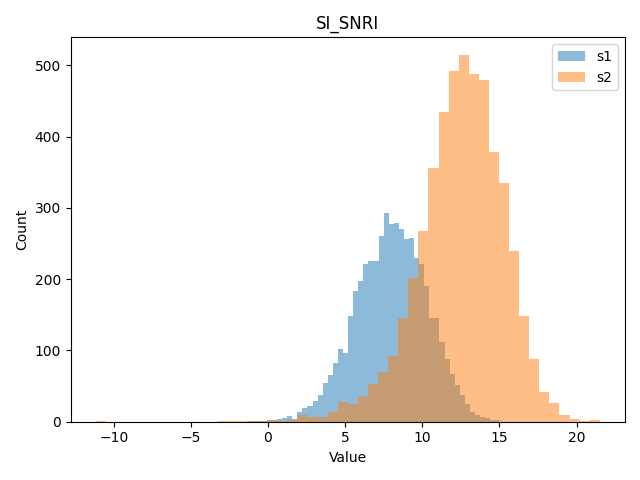

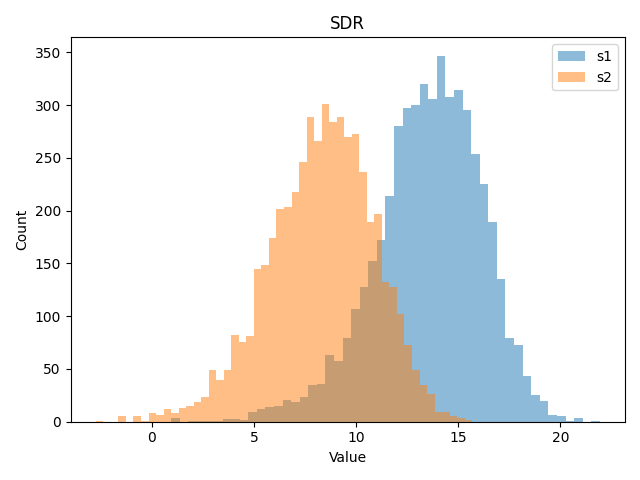

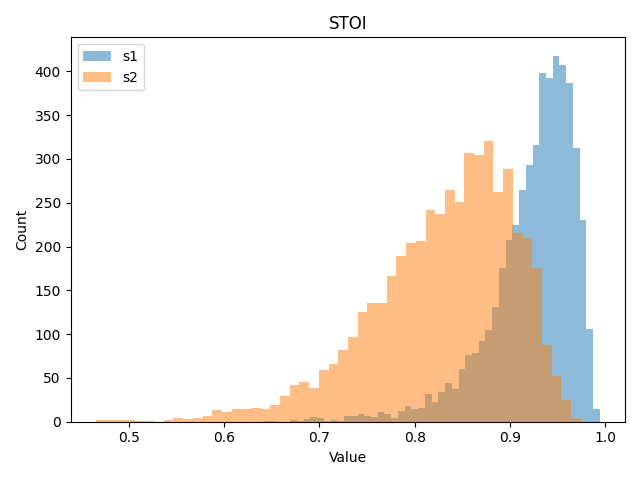

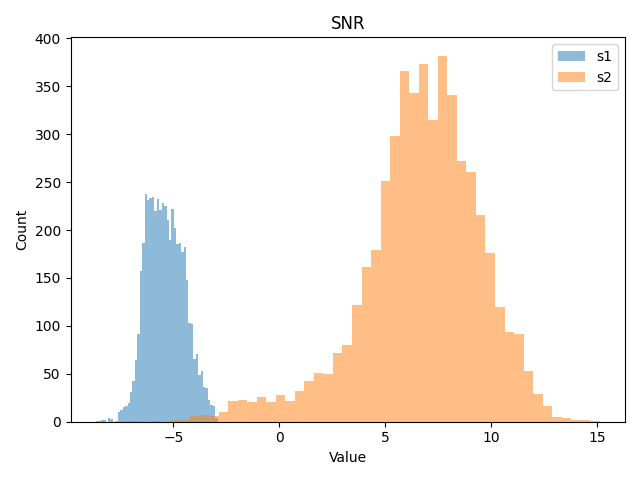

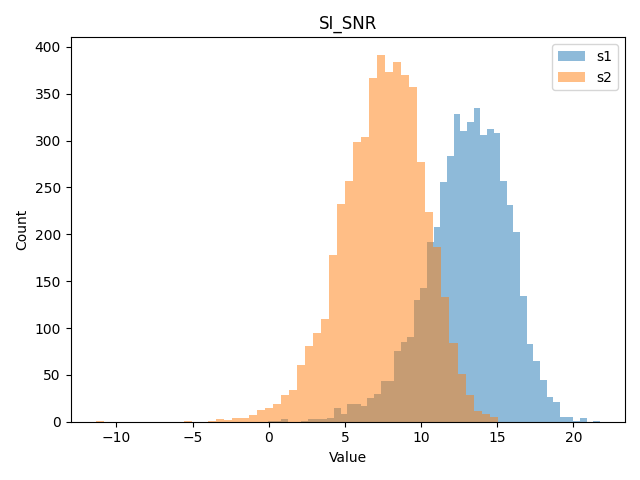

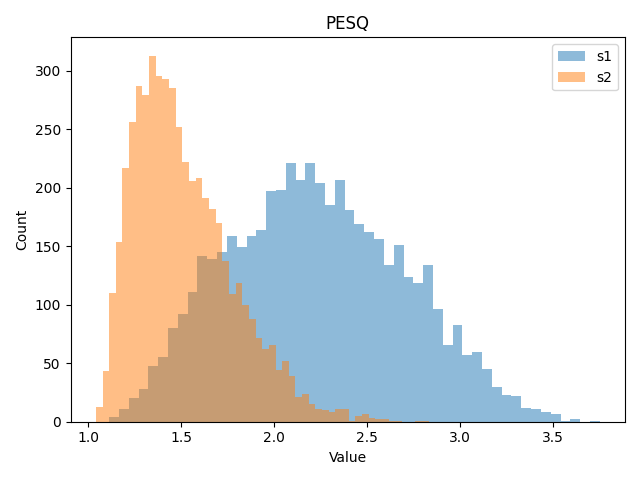

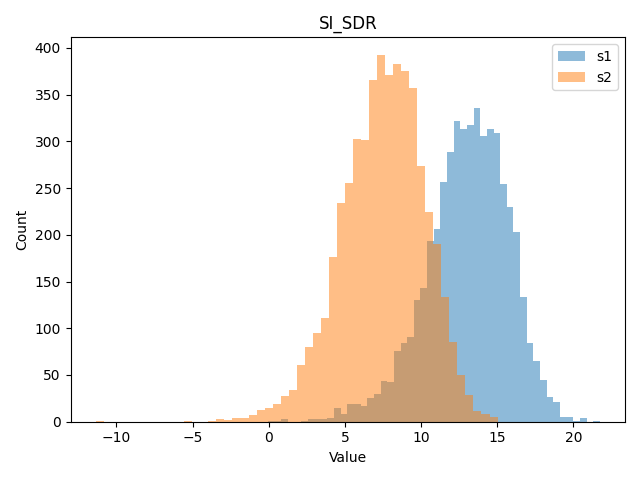

In [15]:
#display metrics distribution over samples
from IPython.display import Image, display

hist_dir = Path("model_outputs/inference") / "metric_histograms"
for p in hist_dir.glob("hist_*.png"):
    display(Image(filename=str(p)))


In [16]:
#speed test of tdfnet_22
!python inference.py +inferencer.speed_test=true datasets.inference.data_dir={root_dir} +datasets.inference.limit=1 dataloader.batch_size=1 model=tdfnet_22 inferencer.from_pretrained="TDFNet/tdfnet_22.pth"

device: cuda
Downloading...
From (original): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE
From (redirected): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE&confirm=t&uuid=e775ccc8-eaa8-4907-acef-14644793069e
To: /content/AVSS-Project/AVSS-Project/lrw_resnet18_dctcn_video.pth
100% 211M/211M [00:00<00:00, 246MB/s]
Loading model weights from: TDFNet/tdfnet_22.pth ...
    batch_size               : 1
    step_time_s              : 0.37558330899992143
    throughput_examples_per_s: 2.662525133672032
    max_memory_bytes         : 455242752
    max_memory_mb            : 434.1533203125
    total_params             : 61480310
    trainable_params         : 8931778
    model_size_bytes         : 35801786
    model_size_mb            : 34.14324378967285
    macs                     : 94343197760.0


In [17]:
#speed test of tdfnet_16
!python inference.py +inferencer.speed_test=true datasets.inference.data_dir={root_dir} +datasets.inference.limit=1 dataloader.batch_size=1 model=tdfnet_16 inferencer.from_pretrained="TDFNet/tdfnet_16.pth"

device: cuda
Downloading...
From (original): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE
From (redirected): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE&confirm=t&uuid=cd08abb9-0df9-489a-b378-76cd35eb36eb
To: /content/AVSS-Project/AVSS-Project/lrw_resnet18_dctcn_video.pth
100% 211M/211M [00:01<00:00, 204MB/s]
Loading model weights from: TDFNet/tdfnet_16.pth ...
    batch_size               : 1
    step_time_s              : 0.28763325600039025
    throughput_examples_per_s: 3.476649445565652
    max_memory_bytes         : 455242752
    max_memory_mb            : 434.1533203125
    total_params             : 61480310
    trainable_params         : 8931778
    model_size_bytes         : 35801786
    model_size_mb            : 34.14324378967285
    macs                     : 81823209536.0


In [18]:
#speed test of rtfsnet
!python inference.py +inferencer.speed_test=true datasets.inference.data_dir={root_dir} +datasets.inference.limit=1 dataloader.batch_size=1 model=rtfsnet inferencer.from_pretrained="RTFSNet/rtfs.pth"

device: cuda
Downloading...
From (original): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE
From (redirected): https://drive.google.com/uc?id=179NgMsHo9TeZCLLtNWFVgRehDvzteMZE&confirm=t&uuid=df091a41-2258-4cc7-a2cf-793d025869c2
To: /content/AVSS-Project/AVSS-Project/lrw_resnet18_dctcn_video.pth
100% 211M/211M [00:22<00:00, 9.22MB/s]
Loading model weights from: RTFSNet/rtfs.pth ...
    batch_size               : 1
    step_time_s              : 0.8009616690001167
    throughput_examples_per_s: 1.2484991962828302
    max_memory_bytes         : 1154705408
    max_memory_mb            : 1101.212890625
    total_params             : 53309557
    trainable_params         : 761025
    model_size_bytes         : 9317952
    model_size_mb            : 8.88629150390625
    macs                     : 125375398400.0
